In [71]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

In [72]:
from tides import Tides
from astro import Astro
mytide = Tides('example_noaa_file.TXT')
mysun = Astro(str(mytide.latitude), str(mytide.longitude),
            mytide.timezone, mytide.year, 'Sun')
mymoon = Astro(str(mytide.latitude), str(mytide.longitude),
            mytide.timezone, mytide.year, 'Moon')

In [76]:
def months_in_year(year_string):
    '''Generator that takes year_string (i.e. '2015') and yields all the months
    of the year in order, also as strings (i.e. '2015-07').
    '''
    start_date = pd.to_datetime(year_string + '-01')    
    end_date = start_date + pd.DateOffset(months = 12)
    current_date = start_date
    while current_date < end_date:
        yield current_date.strftime('%Y-%m')
        current_date = current_date + pd.DateOffset(months = 1)


In [99]:
allmonths = list(months_in_year(mytide.year))
print(allmonths)
month_chunk = [allmonths[:4], allmonths[4:8], 
                   allmonths[8:]]
print(month_chunk)
print(pd.to_datetime(allmonths[1]).strftime('%B'))

['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12']
[['2015-01', '2015-02', '2015-03', '2015-04'], ['2015-05', '2015-06', '2015-07', '2015-08'], ['2015-09', '2015-10', '2015-11', '2015-12']]
February


In [95]:
mytide.annual_max


6.2999999999999998

In [108]:
def yearview(tide_o, sun_o, moon_o):
    """Returns a matplotlib.pyplot Figure object, ready to write to PDF.
    """
    fig = plt.figure(figsize=(8.5,11))
    fig.text(0.5, 0.875, '{} at a Glance'.format(tide_o.year),
             horizontalalignment = 'center', fontsize = '48',
             fontname = 'Alegreya SC')
    
    gs1 = gridspec.GridSpec(2, 3)
    gs1.update(left = 0.05, right = 0.95, bottom = 0.65, top = 0.8,
               wspace = 0.0, hspace = 0.0)
    gs2 = gridspec.GridSpec(2, 3)
    gs2.update(left = 0.05, right = 0.95, bottom = 0.45, top = 0.6,
               wspace = 0.0, hspace = 0.0)
    gs3 = gridspec.GridSpec(2, 3)
    gs3.update(left = 0.05, right = 0.95, bottom = 0.25, top = 0.4,
               wspace = 0.0, hspace = 0.0)
    gs4 = gridspec.GridSpec(2, 3)
    gs4.update(left = 0.05, right = 0.95, bottom = 0.05, top = 0.2,
               wspace = 0.0, hspace = 0.0)
        
    gsx = [gs1, gs2, gs3, gs4]
    allmonths = list(months_in_year(tide_o.year))
    month_chunks = [allmonths[:3], allmonths[3:6], allmonths[6:9], allmonths[9:]]
    
    for chunk, gsi in zip(month_chunks, gsx):
        for ind in [0, 1, 2]:
            month = chunk[ind]
            month_of_sun = sun_o.altitudes[month]
            month_of_moon = moon_o.altitudes[month]
            month_of_tide = tide_o.all_tides[month]

            # convert indices to matplotlib-friendly datetime format
            Si = month_of_sun.index.to_pydatetime()
            Mi = month_of_moon.index.to_pydatetime()
            Ti = month_of_tide.index.to_pydatetime()

            # zeros for plotting the filled area under each curve
            Sz = np.zeros(len(Si))
            Mz = np.zeros(len(Mi))
            Tz = np.zeros(len(Ti))

            # x-limits based on first and last tide interp time - this handles edge
            # cases where only have one or two hi/lo tides per day and interps are
            # somewhat sparse - no more odd cut offs near borders
            start_time = matplotlib.dates.date2num(Ti[0])
            stop_time = matplotlib.dates.date2num(Ti[-1])

            # sun and moon heights on top
            ax1 = plt.subplot(gsi[ind])
            ax1.fill_between(Si, month_of_sun / (np.pi / 2), Sz, color = '#FFEB00',
                             alpha = 1)  # the altitude angle
            ax1.fill_between(Mi, month_of_moon / (np.pi / 2), Mz, color = '#D7A8A8',
                             alpha = 0.25)
            ax1.set_xlim((start_time, stop_time))
            ax1.set_ylim((0, 1))
            ax1.set_xticks([])
            ax1.set_yticks([])
            for side in ['top', 'left', 'right']:
                ax1.spines[side].set_linewidth(1.5)
            ax1.spines['bottom'].set_visible(False)

            # add new moon icon
            new_moon_time = moon_o.phase_day_num[month].idxmin().to_pydatetime()
            ax1.text(new_moon_time, 0.69, '0',   # the dark part
                     ha = 'right', fontsize = 12, color = '0.75',
                     fontname = 'moon phases')
            ax1.text(new_moon_time, 0.69, '*',   # the white part
                     ha = 'right', fontsize = 12, color = '#D7A8A8', alpha = 0.25,
                     fontname = 'moon phases')
            
            # add solstice or equinox icon, if needed this month
            sun_icon_col = {
                'spring equinox':   '#CCFFCC',
                'summer solstice':  '#FFFFA3',
                'fall equinox':     '#D56F28',
                'winter solstice':  '#B4EAF4'
            }
            monthnum = pd.to_datetime(month).month
            if monthnum in sun_o.events.index.month:
                solar_event = sun_o.events[monthnum == sun_o.events.index.month]
                xloc = matplotlib.dates.date2num(solar_event.index[0].to_pydatetime())
                sol_color = sun_icon_col[solar_event[0]]
                ax1.scatter(xloc, 0.25, s=400, marker = (16, 1, 0),
                               facecolor = sol_color, linewidth = 0.5,
                               edgecolor = 'black', zorder = 300, clip_on = False)

            # add month name to top of the box
            month_name = pd.to_datetime(month).strftime('%B')
            plt.text(0.5, 1.08, month_name, horizontalalignment = 'center',
                 fontsize = 12, fontname = 'Alegreya', transform = ax1.transAxes)
                
            # tide magnitudes below
            ax2 = plt.subplot(gsi[ind + 3])
            ax2.fill_between(Ti, month_of_tide, Tz, color = '#52ABB7', alpha = 0.8)
            ax2.set_xlim((start_time, stop_time))
            tide_margin = (tide_o.annual_max - tide_o.annual_min) / 60  # prevent overlap with spines
            ax2.set_ylim((tide_o.annual_min - 1.5 * tide_margin, 
                          tide_o.annual_max + tide_margin))
            ax2.set_xticks([])
            ax2.set_yticks([])
            for side in ['bottom', 'left', 'right']:
                ax2.spines[side].set_linewidth(1.5)
            ax2.spines['top'].set_linewidth(0.5)
            ax2.set_zorder(1500)


    
    return fig



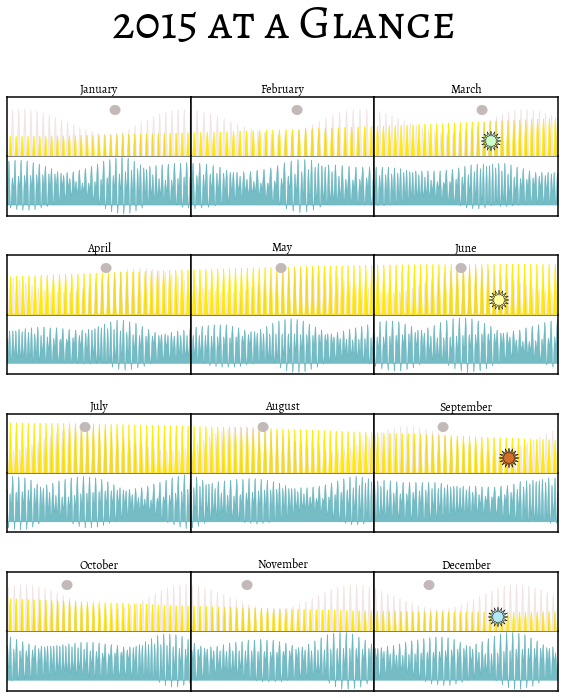

In [109]:
fig = yearview(mytide, mysun, mymoon)
fig.savefig('test.pdf')
